# B-Bot: Question Answering Bot


Initial BERT code adapted from to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
# import sys
# sys.path.append('/drive/MyDrive/Medium')

In [11]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-03-02 06:06:17--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.1’

utils_squad.py.1    100%[===================>]  40.56K  --.-KB/s    in 0s      

2021-03-02 06:06:17 (95.7 MB/s) - ‘utils_squad.py.1’ saved [41529/41529]

--2021-03-02 06:06:17--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

## Loading + Tokenizing SQuAD Data

In [12]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
input_file = '/content/drive/MyDrive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file = input_file,
                                is_training = True,
                                version_2_with_negative = True
                                )

In [ ]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [ ]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [ ]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
111998,57301640b2c2fd1400568831,In what year was a Roman army dispatched to te...,"[Several, years, later,, in, 88, BC,, a, Roman...",88 BC,4,5,False
111999,57301640b2c2fd1400568832,Who was ordered by the senate to become comman...,"[Several, years, later,, in, 88, BC,, a, Roman...",Lucius Cornelius Sulla,32,34,False
112000,57301640b2c2fd1400568833,Who had successfully passed a law whose sole p...,"[Several, years, later,, in, 88, BC,, a, Roman...",Sulla,92,92,False
112001,57301640b2c2fd1400568834,What political party did Lucius Cornelius Sull...,"[Several, years, later,, in, 88, BC,, a, Roman...",populares,61,61,False
112002,57301640b2c2fd1400568835,What happened after Sulla returned to the conf...,"[Several, years, later,, in, 88, BC,, a, Roman...",Marius and Lucius Cornelius Cinna soon took co...,124,134,False


In [ ]:
import random
def print_squad_sample(train_data, line_length = 14, separator_length = 120):
  sample = train_data.sample(frac = 1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [ ]:
print_squad_sample(train_data)

CONTEXT: 
The southern Essonne department specialises in science and technology, and the south-eastern Val-de-Marne, with
its wholesale Rungis food market, specialises in food processing and beverages. The Paris region's
manufacturing decline is quickly being replaced by eco-industries: these employ about 100,000 workers. In
2011, while only 56,927 construction workers worked in Paris itself, its metropolitan area employed
246,639, in an activity centred largely around the Seine-Saint-Denis (41,378) and Hauts-de-Seine (37,303) departments
and the new business-park centres appearing there.
QUESTION:                                                                                            ANSWER:
What does the southern Essonne department specialize in?                                             science and technology
What does south-eastern Val-de-Marne specialize in?                                                  food processing and beverages
How many construction workers worked in 

In [ ]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
21180,56e887cd99e8941900975e69,Where is the national parliment housed?,"[The, Federal, Palace, (Bundeshaus),, built, f...",The Federal Palace,0,2,False,25,39
80906,5727eb304b864d190016401d,Who built Westminster Hall?,"[Following, his, victory, in, the, Battle, of,...",William II,61,62,False,88,27
85512,57283dd13acd2414000df7a5,What was von Neumann's first choice for target...,"[Along, with, four, other, scientists, and, va...",Kyoto,77,77,False,116,52
27904,56fb88f8b28b3419009f1e10,"Along with Turkey, France and Italy, where did...","[Jewish, communities, were, expelled, from, En...",Holland,48,48,False,104,79
52456,572621ec271a42140099d4b9,Buckingham Palace was untouched during which war?,"[During, World, War, I,, the, palace,, then, t...",World War I,1,3,False,115,49


In [ ]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 19414474.27B/s]


In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = '/content/drive/MyDrive/Medium/cache_train'

In [ ]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples = examples,
                                        tokenizer = tokenizer,
                                        max_seq_length = max_seq_length,
                                        doc_stride = doc_stride,
                                        max_query_length = max_query_length,
                                        is_training = True
                                        )
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], 
                             dtype = torch.long
                             )
all_input_mask = torch.tensor([f.input_mask for f in features], 
                              dtype = torch.long
                              )
all_segment_ids = torch.tensor([f.segment_ids for f in features], 
                               dtype = torch.long
                               )
all_cls_index = torch.tensor([f.cls_index for f in features], 
                             dtype = torch.long
                             )
all_p_mask = torch.tensor([f.p_mask for f in features], 
                          dtype = torch.float
                          )

all_start_positions = torch.tensor([f.start_position for f in features], 
                                   dtype = torch.long
                                   )
all_end_positions = torch.tensor([f.end_position for f in features], 
                                 dtype = torch.long)

dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask
                        )

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, 
                              sampler = train_sampler, 
                              batch_size = batch_size, 
                              drop_last = True
                              )

In [ ]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/Medium/checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

## Load Model, Set Params, and Train

Heres the model. Below we see the architecture

In [ ]:
if len(checkpoints) > 0:
  global_step = int(checkpoints[-1].split('-')[-1])
  ckpt_name = '/content/drive/MyDrive/Medium/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint /content/drive/MyDrive/Medium/checkpoint-6000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0211, -0.0491, -0.0209,  ..., -0.0147, -0.0161, -0.0133],
        [ 0.0383,  0.0069,  0.0285,  ..., -0.0193,  0.0269,  0.0145]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0011, 0.0010], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon = 1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc = "Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, 
                          desc = "Iteration"
                          )
    for step, batch in enumerate(epoch_iterator):
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)
      # These are all specific to huggingface's library
      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)
      # save loss as we go
      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
      # Spit out loss every 1000 steps and save checkpoint
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/Medium/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)







Epoch:   0%|          | 0/1 [00:00<?, ?it/s]






Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]






Iteration:   3%|▎         | 238/9016 [00:00<00:03, 2372.69it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Streaming output truncated to the last 5000 lines.

Iteration:  70%|██████▉   | 6286/9016 [03:58<37:53,  1.20it/s]






Iteration:  70%|██████▉   | 6287/9016 [03:58<38:01,  1.20it/s]






Iteration:  70%|██████▉   | 6288/9016 [03:59<37:58,  1.20it/s]






Iteration:  70%|██████▉   | 6289/9016 [04:00<37:57,  1.20it/s]






Iteration:  70%|██████▉   | 6290/9016 [04:01<37:51,  1.20it/s]






Iteration:  70%|██████▉   | 6291/9016 [04:02<37:56,  1.20it/s]






Iteration:  70%|██████▉   | 6292/9016 [04:03<38:00,  1.19it/s]






Iteration:  70%|██████▉   | 6293/9016 [04:03<37:58,  1.19it/s]






Iteration:  70%|██████▉   | 6294/9016 [04:04<37:56,  1.20it/s]






Iteration:  70%|██████▉   | 6295/9016 [04:05<37:59,  1.19it/s]






Iteration:  70%|██████▉   | 6296/9016 [04:06<37:51,  1.20it/s]






Iteration:  70%|██████▉   | 6297/9016 [04:07<37:53,  1.20it/s]






Iteration:  70%|██████▉   | 6298/9016 [04:08<37:55,  1.19it/s]






Iteration:  70%|██████▉   | 6299/9016 [04:08<37:58,

Train loss: 0.1507059286407062









Iteration:  78%|███████▊  | 7001/9016 [13:58<51:59,  1.55s/it]

Saving model checkpoint to /content/drive/MyDrive/Medium/checkpoint-7000


Streaming output truncated to the last 5000 lines.

Iteration:  81%|████████  | 7286/9016 [17:57<24:09,  1.19it/s]






Iteration:  81%|████████  | 7287/9016 [17:57<24:08,  1.19it/s]






Iteration:  81%|████████  | 7288/9016 [17:58<24:05,  1.20it/s]






Iteration:  81%|████████  | 7289/9016 [17:59<24:06,  1.19it/s]






Iteration:  81%|████████  | 7290/9016 [18:00<24:02,  1.20it/s]






Iteration:  81%|████████  | 7291/9016 [18:01<23:56,  1.20it/s]






Iteration:  81%|████████  | 7292/9016 [18:02<23:58,  1.20it/s]






Iteration:  81%|████████  | 7293/9016 [18:02<23:56,  1.20it/s]






Iteration:  81%|████████  | 7294/9016 [18:03<23:52,  1.20it/s]






Iteration:  81%|████████  | 7295/9016 [18:04<23:52,  1.20it/s]






Iteration:  81%|████████  | 7296/9016 [18:05<23:56,  1.20it/s]






Iteration:  81%|████████  | 7297/9016 [18:06<23:53,  1.20it/s]






Iteration:  81%|████████  | 7298/9016 [18:07<23:59,  1.19it/s]






Iteration:  81%|████████  | 7299/9016 [18:07<23:58,

Train loss: 0.26130942975729704









Iteration:  89%|████████▊ | 8001/9016 [27:58<26:01,  1.54s/it]

Saving model checkpoint to /content/drive/MyDrive/Medium/checkpoint-8000


Streaming output truncated to the last 5000 lines.

Iteration:  92%|█████████▏| 8286/9016 [31:57<10:14,  1.19it/s]






Iteration:  92%|█████████▏| 8287/9016 [31:58<10:14,  1.19it/s]






Iteration:  92%|█████████▏| 8288/9016 [31:59<10:12,  1.19it/s]






Iteration:  92%|█████████▏| 8289/9016 [32:00<10:10,  1.19it/s]






Iteration:  92%|█████████▏| 8290/9016 [32:00<10:08,  1.19it/s]






Iteration:  92%|█████████▏| 8291/9016 [32:01<10:08,  1.19it/s]






Iteration:  92%|█████████▏| 8292/9016 [32:02<10:08,  1.19it/s]






Iteration:  92%|█████████▏| 8293/9016 [32:03<10:06,  1.19it/s]






Iteration:  92%|█████████▏| 8294/9016 [32:04<10:04,  1.19it/s]






Iteration:  92%|█████████▏| 8295/9016 [32:05<10:04,  1.19it/s]






Iteration:  92%|█████████▏| 8296/9016 [32:06<10:02,  1.20it/s]






Iteration:  92%|█████████▏| 8297/9016 [32:06<10:00,  1.20it/s]






Iteration:  92%|█████████▏| 8298/9016 [32:07<09:58,  1.20it/s]






Iteration:  92%|█████████▏| 8299/9016 [32:08<10:01,

Train loss: 0.3506137571202384









Iteration: 100%|█████████▉| 9001/9016 [41:59<00:24,  1.63s/it]

Saving model checkpoint to /content/drive/MyDrive/Medium/checkpoint-9000









Iteration: 100%|█████████▉| 9002/9016 [42:00<00:19,  1.40s/it]






Iteration: 100%|█████████▉| 9003/9016 [42:01<00:16,  1.23s/it]






Iteration: 100%|█████████▉| 9004/9016 [42:01<00:13,  1.11s/it]






Iteration: 100%|█████████▉| 9005/9016 [42:02<00:11,  1.03s/it]






Iteration: 100%|█████████▉| 9006/9016 [42:03<00:09,  1.03it/s]






Iteration: 100%|█████████▉| 9007/9016 [42:04<00:08,  1.08it/s]






Iteration: 100%|█████████▉| 9008/9016 [42:05<00:07,  1.11it/s]






Iteration: 100%|█████████▉| 9009/9016 [42:06<00:06,  1.14it/s]






Iteration: 100%|█████████▉| 9010/9016 [42:06<00:05,  1.16it/s]






Iteration: 100%|█████████▉| 9011/9016 [42:07<00:04,  1.17it/s]






Iteration: 100%|█████████▉| 9012/9016 [42:08<00:03,  1.17it/s]






Iteration: 100%|█████████▉| 9013/9016 [42:09<00:02,  1.18it/s]






Iteration: 100%|█████████▉| 9014/9016 [42:10<00:01,  1.18it/s]






Iteration: 100%|█████████▉| 9015/9016 [42:11<00:00,  1.19it/s]






Iteration: 100%|██████████|

In [ ]:
output_dir = '/content/drive/MyDrive/Medium/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/Medium/checkpoint-9000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

Loss is saved during training, easy to pull out and plot. The loss score is the log cross-entropy loss of the softmax layer based on predications at the end of the model architecture

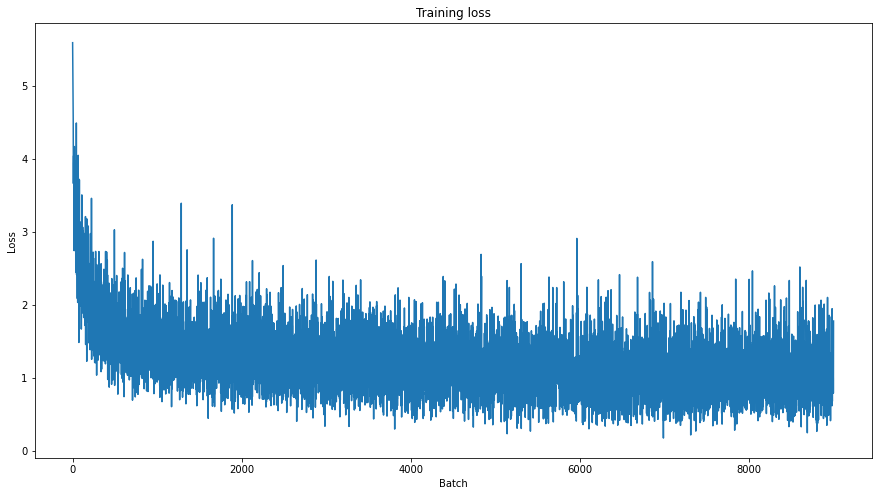

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Based on the graph above, it does not seem that more epochs would improve performance as we see loss plateaus around 5000 on this batch. May be worth trying out though.

Another idea is to further fine-tune on a separate dataset.

# Evaluate Performance - Test Dataset

**Load test dataset**

In [ ]:
input_file = '/content/drive/MyDrive/Medium/dev-v2.0.json'
val_examples = read_squad_examples(input_file = input_file,
                                is_training = False,
                                version_2_with_negative = True
                                )
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/Medium/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset - the masking is key to BERT transformer - masking 15% of tokens
all_input_ids = torch.tensor([f.input_ids for f in features], 
                             dtype = torch.long
                             )
all_input_mask = torch.tensor([f.input_mask for f in features], 
                              dtype = torch.long
                              )
all_segment_ids = torch.tensor([f.segment_ids for f in features], 
                               dtype = torch.long
                               )
all_cls_index = torch.tensor([f.cls_index for f in features], 
                             dtype = torch.long
                             )
all_p_mask = torch.tensor([f.p_mask for f in features], 
                          dtype = torch.float
                          )

all_example_index = torch.arange(all_input_ids.size(0), 
                                 dtype = torch.long
                                 )
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
# SQuAD comes with a validation set

**Evaluate test dataset**

In [ ]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/Medium//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc = "Evaluating", miniters = 100, mininterval = 5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/Medium/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/Medium/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/Medium/null_odds.json"
  output_dir = "/content/drive/MyDrive/Medium/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file = predict_file,
                               pred_file = output_prediction_file,
                               na_prob_file = output_null_log_odds_file,
                               out_image_dir = None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)







Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16








Evaluating:   0%|          | 0/850 [00:15<?, ?it/s]





Evaluating:   8%|▊         | 64/850 [00:16<03:16,  3.99it/s]





Evaluating:  10%|▉         | 84/850 [00:21<03:12,  3.97it/s]





Evaluating:  12%|█▏        | 104/850 [00:26<03:09,  3.94it/s]





Evaluating:  15%|█▍        | 124/850 [00:31<03:06,  3.90it/s]





Evaluating:  17%|█▋        | 143/850 [00:36<03:02,  3.87it/s]





Evaluating:  19%|█▉        | 162/850 [00:41<02:59,  3.84it/s]





Evaluating:  21%|██▏       | 181/850 [00:46<02:54,  3.82it/s]





Evaluating:  24%|██▎       | 200/850 [00:51<02:51,  3.80it/s]





Evaluating:  26%|██▌       | 219/850 [00:56<02:47,  3.76it/s]





Evaluating:  28%|██▊       | 238/850 [01:02<02:44,  3.73it/s]





Evaluating:  30%|███       | 257/850 [01:07<02:40,  3.69it/s]





Evaluating:  32%|███▏      | 275/850 [01:12<02:36,  3.66it/s]





Evaluating:  34%|███▍      | 293/850 [01:17<02:33,  3.63it/s]





Evaluating:  37%|███▋      | 311/850 [01:22<02:29,  3.60it/s]





E

{
  "exact": 68.45784553187906,
  "f1": 71.57303567850235,
  "total": 11873,
  "HasAns_exact": 62.66869095816464,
  "HasAns_f1": 68.90800482639276,
  "HasAns_total": 5928,
  "NoAns_exact": 74.23044575273339,
  "NoAns_f1": 74.23044575273339,
  "NoAns_total": 5945,
  "best_exact": 69.05584098374463,
  "best_exact_thresh": -0.8245954513549805,
  "best_f1": 71.88974520236562,
  "best_f1_thresh": -0.7629053592681885
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

# Q&A - Trained Model

**Loading in the trained model to perform QA predictions!**

In [13]:
import torch
from pytorch_pretrained_bert import BertModel, BertForQuestionAnswering
from pytorch_pretrained_bert import modeling
config = modeling.BertConfig('/content/drive/MyDrive/Medium/checkpoint-final/config.json')
model = modeling.BertForQuestionAnswering(config)
model_state_dict = '/content/drive/MyDrive/Medium/checkpoint-final/pytorch_model.bin'
model.load_state_dict(torch.load(model_state_dict))


<All keys matched successfully>

In [16]:
# !pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

     |████████████████████████████████| 1.9MB 17.8MB/s 
     |████████████████████████████████| 3.2MB 55.1MB/s 


In [39]:
def answer_question(question, answer_text):
    '''
    Takes a `question` and `context` strings (which contains the
    answer) - then find answers in context and print them out. 
    The resulting answers were the highest scored words.
    '''
    # Apply the tokenizer to the inputs
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # Search the input_ids for the first instance of the [SEP] token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf - separates CLS from context
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token
    assert len(segment_ids) == len(input_ids)

    # Run our example question through the model
    # Input_ids are the tokenized questions where segment is the context
    start_scores, end_scores = model(torch.tensor([input_ids]),
                                    token_type_ids = torch.tensor([segment_ids]))

    # Find the tokens with the highest start and end scores - hence the argmax
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the inputs (working backwards)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token
        # This was a smart suggestion....
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Add a space then the token - concat answer
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [40]:
question = "What was Florence Nightingale known as?"
context = "Florence Nightingale (1820-1910), known as “The Lady With the Lamp,” was a British nurse, social reformer and statistician best known as the founder of modern nursing. Her experiences as a nurse during the Crimean War were foundational in her views about sanitation. She established St. Thomas’ Hospital and the Nightingale Training School for Nurses in 1860. Her efforts to reform healthcare greatly influenced the quality of care in the 19 and 20 centuries."

In [42]:
answer_question(question, context)

Query has 101 tokens.

Answer: "lady with the lamp"


Dope

In [22]:
q1 = "What did Florence Nightingale do?"

In [23]:
answer_question (q1, cont)

Query has 100 tokens.

Answer: "nurse"


Note. These predictions may change as the model predicts probability of start/end of word tags.

In [24]:
c2 = "Proponents of strong artificial intelligence (strong AI) and weak AI having exchanged philosophical arguments for a considerable period of time. John R. Searle, albeit being critical toward strong AI, characterized strong AI as assuming that “…the appropriately programmed computer really is a mind, in the sense that computers given the right programs can be literally said to understand and have cognitive states” (Searle, 1980, p. 417). In contrast, weak AI assumes that machines do not have consciousness, mind and sentience but only simulate thought and understanding."

In [25]:
q2 = "What is strong AI?"

In [26]:
# Has a hard time answering this question
answer_question (q2, c2)

Query has 116 tokens.

Answer: "artificial intelligence"


I guess it isn't wrong...

# Plotting CLS - Start + End Scores

In [43]:
# We can see how the token ids match specific words
input_ids = tokenizer.encode(question, context)

tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Zipping strings with tokens
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
what          2,054
was           2,001
florence      7,701
nightingale  21,771
known         2,124
as            2,004
?             1,029

[SEP]           102

florence      7,701
nightingale  21,771
(             1,006
1820         11,102
-             1,011
1910          4,976
)             1,007
,             1,010
known         2,124
as            2,004
“             1,523
the           1,996
lady          3,203
with          2,007
the           1,996
lamp         10,437
,             1,010
”             1,524
was           2,001
a             1,037
british       2,329
nurse         6,821
,             1,010
social        2,591
reformer     24,767
and           1,998
stat         28,093
##istic       6,553
##ian         2,937
best          2,190
known         2,124
as            2,004
the           1,996
founder       3,910
of            1,997
modern        2,715
nursing       8,329
.             1,012
her           2,014
experiences   6,322
as            2,00

In [44]:
input_ids[0:5]

[101, 2054, 2001, 7701, 21771]

In [45]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [46]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids = torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

In [47]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end + 1])

print('Answer: "' + answer + '"')

Answer: "the lady with the lamp"


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = (16,8)

In [49]:
# Pull the scores out of  Tensors and convert them to 1D arrays
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

In [50]:
sns.set(rc={'figure.figsize':(22,8)})


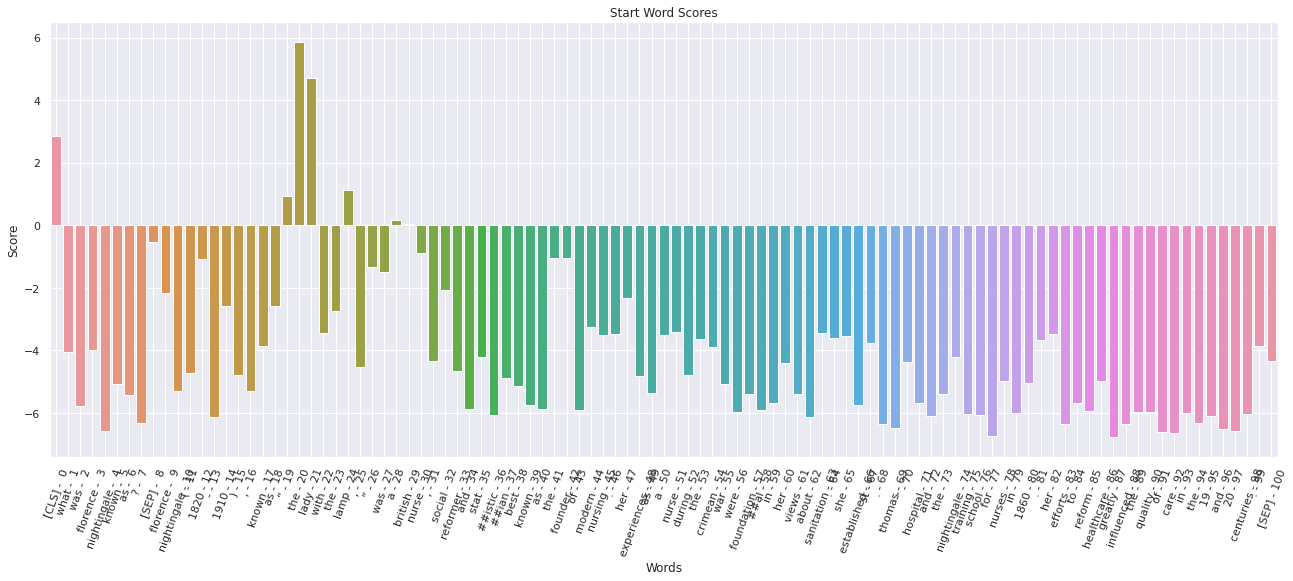

In [51]:
# Create a barplot showing the start word score for all of the tokens
ax = sns.barplot(x = token_labels, 
                 y = s_scores, 
                 ci = None
                 )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 70, 
                   ha = "center"
                   )

ax.grid(True)

ax.set(xlabel = 'Words', 
       ylabel = 'Score'
       )

plt.title('Start Word Scores')

plt.show()

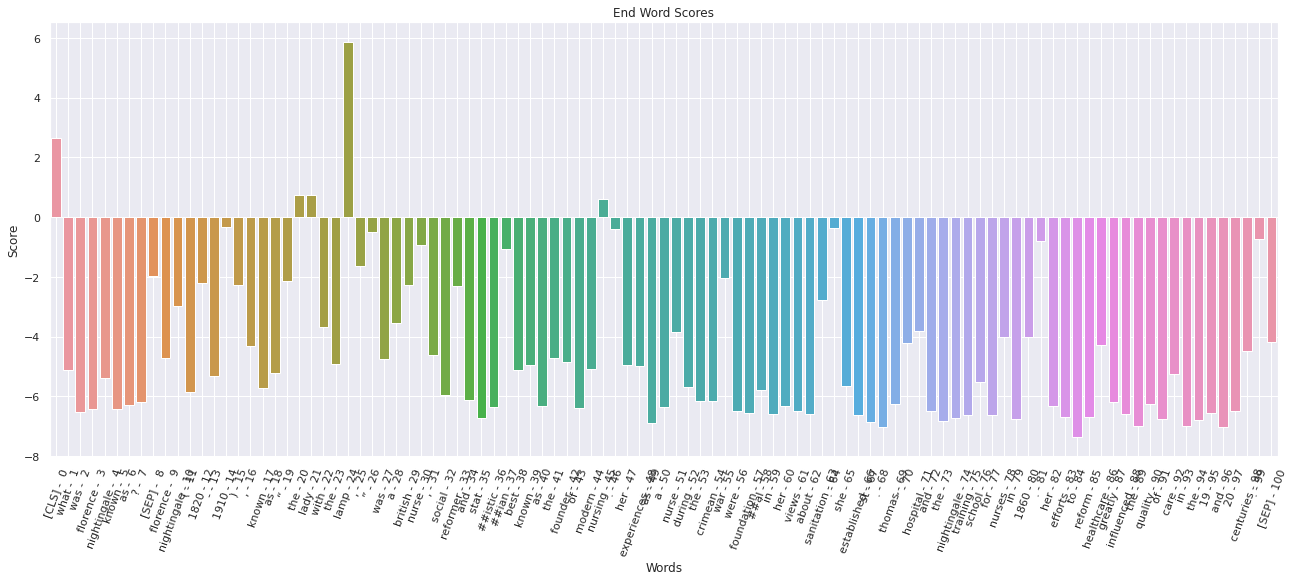

In [52]:
# Create a barplot showing the end word score for all of the tokens
ax = sns.barplot(x = token_labels, 
                 y = e_scores, 
                 ci = None
                 )

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 70, 
                   ha = "center"
                   )

ax.grid(True)

ax.set(xlabel = 'Words', 
       ylabel = 'Score'
       )

plt.title('End Word Scores')

plt.show();

# Further Fine-Tuning

In [53]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [55]:
input_file = '/content/drive/MyDrive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file = input_file,
                                is_training = True,
                                version_2_with_negative = True
                                )

In [56]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [57]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [58]:
import random
# Pulling out context and questions from the SQuAD dictionary
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [59]:
print_squad_sample(train_data)

CONTEXT: 
The first newspaper in Namibia was the German-language Windhoeker Anzeiger, founded 1898. Radio was
introduced in 1969, TV in 1981. During German rule, the newspapers mainly reflected the
living reality and the view of the white German-speaking minority. The black majority was
ignored or depicted as a threat. During South African rule, the white bias continued,
with mentionable influence of the Pretoria government on the "South West African" media system.
Independent newspapers were seen as a menace to the existing order, critical journalists threatened.
QUESTION:                                                                                            ANSWER:
What was the first Namibian newspaper?                                                               Windhoeker Anzeiger
What was the language in which the first Namibian newspaper was printed in?                          German
When was the first Namibian newspaper founded?                                             

In [60]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)


In [61]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [62]:
# Setting some params
doc_stride = 128
max_seq_length = 384
max_query_length = 75
# batch size of 64 if RAM available.
batch_size = 16

In [63]:
# Where to cache sturf
cached_features_file = '/content/drive/MyDrive/Medium/cache_train'

In [64]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples = examples,
                                        tokenizer = tokenizer,
                                        max_seq_length = max_seq_length,
                                        doc_stride = doc_stride,
                                        max_query_length = max_query_length,
                                        is_training = True
                                        )
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [65]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [66]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [67]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [68]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/Medium/checkpoint2*-[0-9]*'))

In [69]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [70]:
if len(checkpoints) > 0:
  global_step = int(checkpoints[-1].split('-')[-1])
  ckpt_name = '/content/drive/MyDrive/Medium/checkpoint2-6000'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda();

Loading model from checkpoint /content/drive/MyDrive/Medium/checkpoint2-6000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
        

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0117,  0.0102,  0.0359,  ..., -0.0358, -0.0085,  0.0153],
        [-0.0088, -0.0326, -0.0064,  ...,  0.0188, -0.0068,  0.0077]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0044, 0.0045], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 3e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/Medium/checkpoint2-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 34/9016 [00:00<00:40, 224.24it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016



Iteration:  77%|███████▋  | 6986/9016 [00:03<00:01, 1985.34it/s]/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  89%|████████▊ | 8000/9016 [13:28<13:59,  1.21it/s]

Train loss: 0.13330947039090096



Iteration:  89%|████████▊ | 8001/9016 [13:31<27:01,  1.60s/it]

Saving model checkpoint to /content/drive/MyDrive/Medium/checkpoint2-8000



Iteration: 100%|█████████▉| 9000/9016 [27:16<00:13,  1.22it/s]

Train loss: 0.23508419280747572



Iteration: 100%|█████████▉| 9001/9016 [27:19<00:24,  1.62s/it]

Saving model checkpoint to /content/drive/MyDrive/Medium/checkpoint2-9000



Epoch: 100%|██████████| 1/1 [27:32<00:00, 1652.16s/it]


## Evaluate Round 2

In [ ]:
doc_stride = 128
max_seq_length = 384
max_query_length = 75
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
input_file = '/content/drive/MyDrive/Medium/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 384
max_query_length = 75
cached_features_file = '/content/drive/MyDrive/Medium/cache_validation2'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
global_step = int(checkpoints[-1].split('-')[-1])
ckpt_name = '/content/drive/MyDrive/Medium/checkpoint2-9000'.format(global_step)


model = BertForQuestionAnswering.from_pretrained(ckpt_name)

**Evaluate test dataset**

Ran into error while trying to evalutate a second time

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/Medium/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc = "Evaluating", miniters = 100, mininterval = 5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/Medium/predictions2.json"
  output_nbest_file = "/content/drive/MyDrive/Medium/nbest_predictions2.json"
  output_null_log_odds_file = "/content/drive/MyDrive/Medium/null_odds2.json"
  output_dir = "/content/drive/MyDrive/Medium/predict_results2"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file = predict_file,
                               pred_file = output_prediction_file,
                               na_prob_file = output_null_log_odds_file,
                               out_image_dir = None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer) # Honestly... not really sure what the error is here.

Evaluating:   0%|          | 0/764 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 12232
  Batch size = 16


RuntimeError: ignored

In [ ]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/Medium/checkpoint2-9000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

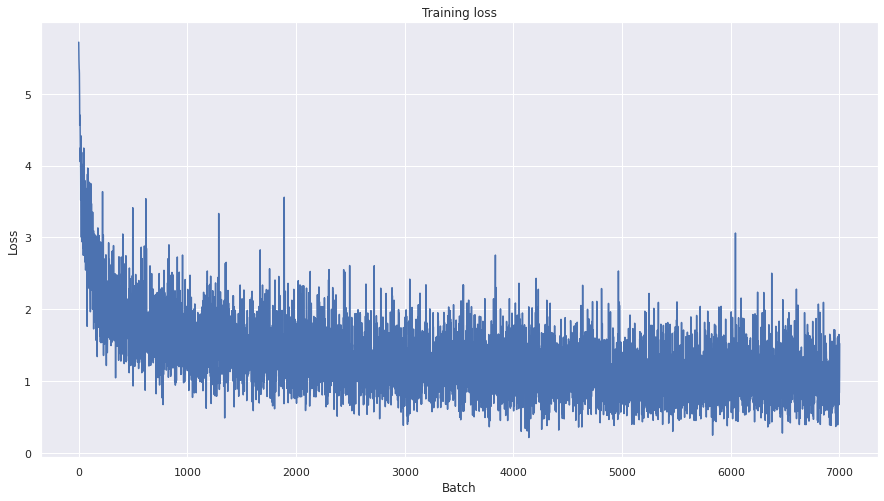

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
import torch
from pytorch_pretrained_bert import BertModel, BertForQuestionAnswering
from pytorch_pretrained_bert import modeling
config = modeling.BertConfig('/content/drive/MyDrive/Medium/checkpoint2-9000/config.json')
model = modeling.BertForQuestionAnswering(config)
model_state_dict = '/content/drive/MyDrive/Medium/checkpoint2-9000/pytorch_model.bin'
model.load_state_dict(torch.load(model_state_dict))


<All keys matched successfully>

In [ ]:
# Repeat QA, see how it does now

In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids = torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [ ]:
question = "How many parameters does BERT-large have?"
context = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [ ]:
question

'How many parameters does BERT-large have?'

In [ ]:
question = "What is Ada often known as?"
context = "Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852) was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation, and to have published the first algorithm intended to be carried out by such a machine. As a result, she is often regarded as one of the first computer programmers."

In [ ]:
question = "What is Ada often known as?"

In [ ]:
answer_question(question, context)

Query has 108 tokens.

Answer: "one of the first computer programmers"


In [ ]:
q = "What did Florence Nightingale do?"
cont = "Florence Nightingale (1820-1910), known as “The Lady With the Lamp,” was a British nurse, social reformer and statistician best known as the founder of modern nursing. Her experiences as a nurse during the Crimean War were foundational in her views about sanitation. She established St. Thomas’ Hospital and the Nightingale Training School for Nurses in 1860. Her efforts to reform healthcare greatly influenced the quality of care in the 19 and 20 centuries."

In [ ]:
answer_question(q, cont)

Query has 100 tokens.

Answer: "a british nurse , social reformer and statistician best known as the founder of modern nursing"


Actually seemingly better performance after a second epoch. The first rendition strugged with many of these.

#Appendix

## Moving On... Improving Q&A Functions

In [ ]:
from transformers.data.processors.squad import SquadV2Processor

# this processor loads the SQuAD2.0 dev set examples
processor = SquadV2Processor()
examples = processor.get_dev_examples("/content/drive/MyDrive/Medium/", filename="dev-v2.0.json")
print(len(examples))

100%|██████████| 35/35 [00:03<00:00,  9.02it/s]


11873


In [ ]:
# generate some maps to help us identify examples of interest
qid_to_example_index = {example.qas_id: i for i, example in enumerate(examples)}
qid_to_has_answer = {example.qas_id: bool(example.answers) for example in examples}
answer_qids = [qas_id for qas_id, has_answer in qid_to_has_answer.items() if has_answer]
no_answer_qids = [qas_id for qas_id, has_answer in qid_to_has_answer.items() if not has_answer]

In [ ]:
def display_example(qid):    
    from pprint import pprint

    idx = qid_to_example_index[qid]
    q = examples[idx].question_text
    c = examples[idx].context_text
    a = [answer['text'] for answer in examples[idx].answers]
    
    print(f'Example {idx} of {len(examples)}\n---------------------')
    print(f"Q: {q}\n")
    print("Context:")
    pprint(c)
    print(f"\nTrue Answers:\n{a}")

In [ ]:
display_example(answer_qids[1414])

Example 2790 of 11873
---------------------
Q: Interest groups and government agencies that were concerned with energy were no match for who?

Context:
('In the United States, scholars argue that there already existed a negotiated '
 'settlement based on equality between both parties prior to 1973. The '
 'possibility that the Middle East could become another superpower '
 'confrontation with the USSR was of more concern to the US than oil. Further, '
 'interest groups and government agencies more worried about energy were no '
 "match for Kissinger's dominance. In the US production, distribution and "
 'price disruptions "have been held responsible for recessions, periods of '
 'excessive inflation, reduced productivity, and lower economic growth."')

True Answers:
['Kissinger', 'Kissinger', 'Kissinger', "Kissinger's", 'Kissinger']


Positive example... there is a right answer! In this case, the top 5 are Kissinger('s)

In [ ]:
display_example(no_answer_qids[1414])

Example 2860 of 11873
---------------------
Q: What are the results of policies that use renewable energy?

Context:
('The energy crisis led to greater interest in renewable energy, nuclear power '
 'and domestic fossil fuels. There is criticism that American energy policies '
 'since the crisis have been dominated by crisis-mentality thinking, promoting '
 'expensive quick fixes and single-shot solutions that ignore market and '
 'technology realities. Instead of providing stable rules that support basic '
 'research while leaving plenty of scope for entrepreneurship and innovation, '
 'congresses and presidents have repeatedly backed policies which promise '
 'solutions that are politically expedient, but whose prospects are doubtful.')

True Answers:
[]


Negative example... there is no single clear answer. Best response is no response for our B-Bot

Exact Match
This metric is as simple as it sounds. For each question+answer pair, if the characters of the model's prediction exactly match the characters of (one of) the True Answer(s), EM = 1, otherwise EM = 0. This is a strict all-or-nothing metric; being off by a single character results in a score of 0. When assessing against a negative example, if the model predicts any text at all, it automatically receives a 0 for that example.

F1
F1 score is a common metric for classification problems, and widely used in QA. It is appropriate when we care equally about precision and recall. In this case, it's computed over the individual words in the prediction against those in the True Answer. The number of shared words between the prediction and the truth is the basis of the F1 score: precision is the ratio of the number of shared words to the total number of words in the prediction, and recall is the ratio of the number of shared words to the total number of words in the ground truth.

In [ ]:
def get_prediction(qid):
    # given a question id (qas_id or qid), load the example, get the model outputs and generate an answer
    question = examples[qid_to_example_index[qid]].question_text
    context = examples[qid_to_example_index[qid]].context_text

    inputs = tokenizer.encode_plus(question, context, return_tensors='pt')

    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1 

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer

In [ ]:
# these functions are heavily influenced by the HF squad_metrics.py script
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

def get_gold_answers(example):
    """helper function that retrieves all possible true answers from a squad2.0 example"""
    
    gold_answers = [answer["text"] for answer in example.answers if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
        
    return gold_answers

In [ ]:
prediction = get_prediction(answer_qids[4141])
example = examples[qid_to_example_index[answer_qids[4141]]]

gold_answers = get_gold_answers(example)

em_score = max((compute_exact_match(prediction, answer)) for answer in gold_answers)
f1_score = max((compute_f1(prediction, answer)) for answer in gold_answers)

print(f"Question: {example.question_text}")
print(f"Prediction: {prediction}")
print(f"True Answers: {gold_answers}")
print(f"EM: {em_score} \t F1: {f1_score}")

Question: Primitive jawless vertebrates possess an array of receptors referred to as what?
Prediction: lymphocyte receptors
True Answers: ['Variable lymphocyte receptors (VLRs)', 'Variable lymphocyte receptors', 'Variable lymphocyte receptors (VLRs)']
EM: 0 	 F1: 0.8


In [ ]:
prediction = get_prediction(no_answer_qids[1254])
example = examples[qid_to_example_index[no_answer_qids[1254]]]

gold_answers = get_gold_answers(example)

em_score = max((compute_exact_match(prediction, answer)) for answer in gold_answers)
f1_score = max((compute_f1(prediction, answer)) for answer in gold_answers)

print(f"Question: {example.question_text}")
print(f"Prediction: {prediction}")
print(f"True Answers: {gold_answers}")
print(f"EM: {em_score} \t F1: {f1_score}")

Question: What happened 3.7-2 billion years ago?
Prediction: [CLS]
True Answers: ['']
EM: 0 	 F1: 0


In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

# convert our start and end logit tensors to lists
start_logits = to_list(start_logits)[0]
end_logits = to_list(end_logits)[0]

# sort our start and end logits from largest to smallest, keeping track of the index
start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

# select the top n (in this case, 5)
print(start_idx_and_logit[:5])
print(end_idx_and_logit[:5]) 

[(17, 3.182528018951416), (0, 3.1627042293548584), (15, 3.0516319274902344), (14, 2.4494309425354004), (16, 2.0854928493499756)]
[(22, 3.603154420852661), (15, 3.575319290161133), (0, 3.4628281593322754), (21, -0.20630934834480286), (34, -0.5445519685745239)]


In [ ]:
start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

# convert the token ids from a tensor to a list
tokens = to_list(inputs['input_ids'])[0]

# question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]
question_indexes

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
import collections

# keep track of all preliminary predictions
PrelimPrediction = collections.namedtuple( 
    "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
)

prelim_preds = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # throw out invalid predictions
        if start_index in question_indexes:
            continue
        if end_index in question_indexes:
            continue
        if end_index < start_index:
            continue
        prelim_preds.append(
            PrelimPrediction(
                start_index = start_index,
                end_index = end_index,
                start_logit = start_logits[start_index],
                end_logit = end_logits[end_index]
            )
        )

In [ ]:
from pprint import pprint
# sort preliminary predictions by their score
prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)
pprint(prelim_preds[:5])

[PrelimPrediction(start_index=17, end_index=22, start_logit=3.182528018951416, end_logit=3.603154420852661),
 PrelimPrediction(start_index=0, end_index=22, start_logit=3.1627042293548584, end_logit=3.603154420852661),
 PrelimPrediction(start_index=0, end_index=15, start_logit=3.1627042293548584, end_logit=3.575319290161133),
 PrelimPrediction(start_index=15, end_index=22, start_logit=3.0516319274902344, end_logit=3.603154420852661),
 PrelimPrediction(start_index=15, end_index=15, start_logit=3.0516319274902344, end_logit=3.575319290161133)]


In [ ]:
# keep track of all best predictions
BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
    "BestPrediction", ["text", "start_logit", "end_logit"]
)

nbest = []
seen_predictions = []
for pred in prelim_preds:
    
    # for now we only care about the top 5 best predictions
    if len(nbest) >= 5: 
        break
        
    # loop through predictions according to their start index
    if pred.start_index > 0: # non-null answers have start_index > 0

        text = tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(
                tokens[pred.start_index:pred.end_index+1]
            )
        )
        # clean whitespace
        text = text.strip()
        text = " ".join(text.split())

        if text in seen_predictions:
            continue

        # flag this text as being seen -- if we see it again, don't add it to the nbest list
        seen_predictions.append(text) 

        # add this text prediction to a pruned list of the top 5 best predictions
        nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

# and don't forget -- include the null answer!
nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

pprint(nbest)

[BestPrediction(text="the world ' s water bodies", start_logit=3.182528018951416, end_logit=3.603154420852661),
 BestPrediction(text="solution in the world ' s water bodies", start_logit=3.0516319274902344, end_logit=3.603154420852661),
 BestPrediction(text='solution', start_logit=3.0516319274902344, end_logit=3.575319290161133),
 BestPrediction(text="in solution in the world ' s water bodies", start_logit=2.4494309425354004, end_logit=3.603154420852661),
 BestPrediction(text='in solution', start_logit=2.4494309425354004, end_logit=3.575319290161133),
 BestPrediction(text='', start_logit=3.1627042293548584, end_logit=3.4628281593322754)]


In [ ]:
# compute the null score as the sum of the [CLS] token logits
score_null = start_logits[0] + end_logits[0]

# compute the difference between the null score and the best non-null score
score_diff = score_null - nbest[0].start_logit - nbest[0].end_logit

score_diff

-0.16015005111694336

In [ ]:
model_dir = '/content/drive/MyDrive/Medium/'
import json

In [ ]:
filename = model_dir + 'null_odds.json'
null_odds = json.load(open(filename, 'rb'))

null_odds[example.qas_id]

6.900971882045269

In [ ]:
# load the predictions we generated earlier
filename = model_dir + 'predictions.json'
preds = json.load(open(filename, 'rb'))

In [ ]:
from transformers.data.metrics.squad_metrics import squad_evaluate

# the default threshold is set to 1.0 -- we'll leave it there for now
results_default_thresh = squad_evaluate(examples, 
                                        preds, 
                                        no_answer_probs=null_odds, 
                                        no_answer_probability_threshold=1.0)

pprint(results_default_thresh)

OrderedDict([('exact', 68.45784553187906),
             ('f1', 71.57303567850235),
             ('total', 11873),
             ('HasAns_exact', 62.66869095816464),
             ('HasAns_f1', 68.90800482639276),
             ('HasAns_total', 5928),
             ('NoAns_exact', 74.23044575273339),
             ('NoAns_f1', 74.23044575273339),
             ('NoAns_total', 5945),
             ('best_exact', 69.05584098374463),
             ('best_exact_thresh', -0.8245954513549805),
             ('best_f1', 71.88974520236562),
             ('best_f1_thresh', -0.7629053592681885)])


In [ ]:
best_f1_thresh = -0.7629053592681885
results_f1_thresh = squad_evaluate(examples, 
                                   preds, 
                                   no_answer_probs=null_odds, 
                                   no_answer_probability_threshold=best_f1_thresh)

pprint(results_f1_thresh)

OrderedDict([('exact', 69.03057357028553),
             ('f1', 71.88974520236572),
             ('total', 11873),
             ('HasAns_exact', 59.176788124156545),
             ('HasAns_f1', 64.90333076715353),
             ('HasAns_total', 5928),
             ('NoAns_exact', 78.85618166526493),
             ('NoAns_f1', 78.85618166526493),
             ('NoAns_total', 5945),
             ('best_exact', 69.05584098374463),
             ('best_exact_thresh', -0.8245954513549805),
             ('best_f1', 71.88974520236562),
             ('best_f1_thresh', -0.7629053592681885)])


Using the improved Best Answer evaluator, we improved our "No Answer" F1 Score by 4%. This improved method better handles the questions with no right answer.

In [ ]:
def get_robust_prediction(example, tokenizer, nbest=10, null_threshold=1.0):
    
    inputs = get_qa_inputs(example, tokenizer)
    start_logits, end_logits = model(**inputs)

    # get sensible preliminary predictions, sorted by score
    prelim_preds = preliminary_predictions(start_logits, 
                                           end_logits, 
                                           inputs['input_ids'],
                                           nbest)
    
    # narrow that down to the top nbest predictions
    nbest_preds = best_predictions(prelim_preds, nbest, tokenizer)

    # compute the probability of each prediction - nice but not necessary
    probabilities = prediction_probabilities(nbest_preds)
        
    # compute score difference
    score_difference = compute_score_difference(nbest_preds)

    # if score difference > threshold, return the null answer
    if score_difference > null_threshold:
        return "", probabilities[-1]
    else:
        return nbest_preds[0].text, probabilities[0]

In [ ]:

# ----------------- Helper functions for get_robust_prediction ----------------- #
def get_qa_inputs(example, tokenizer):
    # load the example, convert to inputs, get model outputs
    question = example.question_text
    context = example.context_text
    return tokenizer.encode_plus(question, context, return_tensors='pt')

def get_clean_text(tokens, tokenizer):
    text = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(tokens)
        )
    # Clean whitespace
    text = text.strip()
    text = " ".join(text.split())
    return text

def prediction_probabilities(predictions):

    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    all_scores = [pred.start_logit+pred.end_logit for pred in predictions] 
    return softmax(np.array(all_scores))

def preliminary_predictions(start_logits, end_logits, input_ids, nbest):
    # convert tensors to lists
    start_logits = to_list(start_logits)[0]
    end_logits = to_list(end_logits)[0]
    tokens = to_list(input_ids)[0]

    # sort our start and end logits from largest to smallest, keeping track of the index
    start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
    end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)
    
    start_indexes = [idx for idx, logit in start_idx_and_logit[:nbest]]
    end_indexes = [idx for idx, logit in end_idx_and_logit[:nbest]]

    # question tokens are between the CLS token (101, at position 0) and first SEP (102) token 
    question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

    # keep track of all preliminary predictions
    PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
    )
    prelim_preds = []
    for start_index in start_indexes:
        for end_index in end_indexes:
            # throw out invalid predictions
            if start_index in question_indexes:
                continue
            if end_index in question_indexes:
                continue
            if end_index < start_index:
                continue
            prelim_preds.append(
                PrelimPrediction(
                    start_index = start_index,
                    end_index = end_index,
                    start_logit = start_logits[start_index],
                    end_logit = end_logits[end_index]
                )
            )
    # sort prelim_preds in descending score order
    prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)
    return prelim_preds

def best_predictions(prelim_preds, nbest, tokenizer):
    # keep track of all best predictions

    # This will be the pool from which answer probabilities are computed 
    BestPrediction = collections.namedtuple(
        "BestPrediction", ["text", "start_logit", "end_logit"]
    )
    nbest_predictions = []
    seen_predictions = []
    for pred in prelim_preds:
        if len(nbest_predictions) >= nbest: 
            break
        if pred.start_index > 0: # non-null answers have start_index > 0

            toks = tokens[pred.start_index : pred.end_index+1]
            text = get_clean_text(toks, tokenizer)

            # if this text has been seen already - skip it
            if text in seen_predictions:
                continue

            # flag text as being seen
            seen_predictions.append(text) 

            # add this text to a pruned list of the top nbest predictions
            nbest_predictions.append(
                BestPrediction(
                    text=text, 
                    start_logit=pred.start_logit,
                    end_logit=pred.end_logit
                    )
                )
        
    # Add the null prediction
    nbest_predictions.append(
        BestPrediction(
            text="", 
            start_logit=start_logits[0], 
            end_logit=end_logits[0]
            )
        )
    return nbest_predictions

def compute_score_difference(predictions):
    """ Assumes that the null answer is always the last prediction """
    score_null = predictions[-1].start_logit + predictions[-1].end_logit
    score_non_null = predictions[0].start_logit + predictions[0].end_logit
    return score_null - score_non_null

In [ ]:
print(example.question_text)
get_robust_prediction(example, tokenizer, nbest=10, null_threshold=8.0)

What happened 3.7-2 billion years ago?


('amounts of o 2 in eutrophic water', 0.013113865788864174)

In [ ]:
print(example.question_text)
get_robust_prediction(example, tokenizer, nbest=10, null_threshold=1.0)

What happened 3.7-2 billion years ago?


('', 0.9896824654211608)

##Chunking



Done following Fast Forward Labs example

In [ ]:
"class DocumentReader:
    def __init__(self, pretrained_model_name_or_path='bert-base-uncased'):
        self.READER_PATH = pretrained_model_name_or_path
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = modeling.BertForQuestionAnswering(config)
        self.max_len = self.model.config.max_position_embeddings
        self.chunked = False
        self.model_state_dict = '/content/drive/MyDrive/Medium/checkpoint-final/pytorch_model.bin'
        self.model.load_state_dict(torch.load(model_state_dict))

    def tokenize(self, question, text):
        self.inputs = self.tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt")
        self.input_ids = self.inputs["input_ids"].tolist()[0]

        if len(self.input_ids) > self.max_len:
            self.inputs = self.chunkify()
            self.chunked = True

    def chunkify(self):
        """ 
        Break up a long article into chunks that fit within the max token
        requirement for that Transformer model. 

        Calls to BERT / RoBERTa / ALBERT require the following format:
        [CLS] question tokens [SEP] context tokens [SEP].
        """

        # create question mask based on token_type_ids
        # value is 0 for question tokens, 1 for context tokens
        qmask = self.inputs['token_type_ids'].lt(1)
        qt = torch.masked_select(self.inputs['input_ids'], qmask)
        chunk_size = self.max_len - qt.size()[0] - 1 # the "-1" accounts for
        # having to add an ending [SEP] token to the end

        # create a dict of dicts; each sub-dict mimics the structure of pre-chunked model input
        chunked_input = OrderedDict()
        for k,v in self.inputs.items():
            q = torch.masked_select(v, qmask)
            c = torch.masked_select(v, ~qmask)
            chunks = torch.split(c, chunk_size)
            
            for i, chunk in enumerate(chunks):
                if i not in chunked_input:
                    chunked_input[i] = {}

                thing = torch.cat((q, chunk))
                if i != len(chunks)-1:
                    if k == 'input_ids':
                        thing = torch.cat((thing, torch.tensor([102])))
                    else:
                        thing = torch.cat((thing, torch.tensor([1])))

                chunked_input[i][k] = torch.unsqueeze(thing, dim=0)
        return chunked_input

    def get_answer(self):
        if self.chunked:
            answer = ''
            for k, chunk in self.inputs.items():
                answer_start_scores, answer_end_scores = self.model(**chunk)

                answer_start = torch.argmax(answer_start_scores)
                answer_end = torch.argmax(answer_end_scores) + 1

                ans = self.convert_ids_to_string(chunk['input_ids'][0][answer_start:answer_end])
                if ans != '[CLS]':
                    answer += ans + " / "
            return answer
        else:
            answer_start_scores, answer_end_scores = self.model(**self.inputs)

            answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
            answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
        
            return self.convert_ids_to_string(self.inputs['input_ids'][0][
                                              answer_start:answer_end])

    def convert_ids_to_string(self, input_ids):
        return self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(input_ids))

In [ ]:
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

In [ ]:
!pip install wikipedia


  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=1a99ca69dc9f9326e2c73206d5d5066b6b78bf46c62b70dfa43f3791dce741bf
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


##Pseudo Elastic Search - Wiki Articles

In [ ]:
import wikipedia as wiki
import pprint as pp

question = 'What is the wingspan of an albatross?'

results = wiki.search(question)
print("Wikipedia search results for our question:\n")
pp.pprint(results)

page = wiki.page(results[0])
text = page.content
print(f"\nThe {results[0]} Wikipedia article contains {len(text)} characters.")

Wikipedia search results for our question:

['Albatross',
 'List of largest birds',
 'Black-browed albatross',
 'List of birds by flight speed',
 'Mollymawk',
 'Argentavis',
 'Largest body part',
 'Pterosaur',
 'Aspect ratio (aeronautics)',
 'Pteranodon']

The Albatross Wikipedia article contains 38408 characters.


In [ ]:
from collections import OrderedDict
import pprint as pprint

In [ ]:
questions = [
    'When was Obama born?',
    'Why is the sky blue?',
    'How many sides does a pentagon have?'
]

reader = DocumentReader(model) 

# if you trained your own model using the training cell earlier, you can access it with this:
#reader = DocumentReader("./models/bert/bbu_squad2")

for question in questions:
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0])
    print(f"Top wiki result: {page}")

    text = page.content

    reader.tokenize(question, text)
    print(f"Answer: {reader.get_answer()}")
    print()

Question: When was Obama born?
Top wiki result: <WikipediaPage 'Family of Barack Obama'>


Token indices sequence length is longer than the specified maximum sequence length for this model (9135 > 512). Running this sequence through the model will result in indexing errors


Answer: [CLS] when was obama born ? [SEP] the family of barack obama , the 44th president of the united states , and his wife michelle obama is made up of people of kenyan ( luo ) , african - american , and old stock american ( including originally english , scots - irish , welsh , german , and swiss ) ancestry . their immediate family was the first family of the united states from 2009 to 2017 / 1925 / 1835 /  / 2002 / [CLS] when was obama born ? [SEP] in 1986 and re - issued in 1992 . an immigration judge ruled on january 30 , 2013 , that onyango obama would receive a deportation hearing . onyango ' s attorneys said that his defense at the december 3 , 2013 , deportation hearing would be a reliance on the immigration reform and control act of 1986 , because onyango had resided in the u . s . since before january 1 , 1972 , the cutoff date of the 1986 amnesty . at the hearing , immigration judge leonard i . shapiro ruled that onyango was eligible for permanent residence and would rece

In [ ]:
questions = [
    'When was Obama born?',
    'Why is the sky blue?',
    'How many sides does a pentagon have?'
]

reader = DocumentReader('/content/drive/MyDrive/Medium/checkpoint-final/pytorch_model.bin') 

# if you trained your own model using the training cell earlier, you can access it with this:
#reader = DocumentReader("./models/bert/bbu_squad2")

for question in questions:
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0])
    print(f"Top wiki result: {page}")

    text = page.content

    reader.tokenize(question, text)
    print(f"Answer: {reader.get_answer()}")
    print()

Question: When was Obama born?
Top wiki result: <WikipediaPage 'Family of Barack Obama'>


Token indices sequence length is longer than the specified maximum sequence length for this model (9135 > 512). Running this sequence through the model will result in indexing errors


Answer:  /  / use of microcredit in order to combat global poverty . the ann dunham soetoro endowment in the anthropology department at the university of hawaiʻi at man /  /  /  / . = = = robert wolfley ( 1835 – 1895 ) = = = robert wolfley , born in 1835 , is one of obama ' s maternal third great - grandfathers . he served as a private in company a , 145th ohio infantry during the american civil / . records do not survive ; all such documentation was routinely destroyed after six years by the colonial administration . onyango was then subject to torture due to suspicions that he was an associate of the mau mau rebels . in his memoir , obama recounted family descriptions of his grandfather ' s shocking physical state when released from prison : " when he returned to alego he was very thin and dirty . he had difficulty walking , and his head was full of lice . " for some time , he was too traumatized to speak about his experiences . his wife told his grandson obama : " from that day on ,

In [ ]:
reader